In [1]:
import pandas as pd
import numpy as np
import sqlite3
import requests
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
%matplotlib inline

sns.set(rc={'figure.figsize':(20, 5)})

In [2]:
def geocoder_district(lon, lat, key):
    url = 'https://geocode-maps.yandex.ru/1.x'
    
    params = {'format':'json', 'apikey': key, 'geocode': str(lon) + ',' + str(lat), 'kind':'district'}
    response = requests.get(url, params=params)
    
    # Округ
    district = response.json()["response"]["GeoObjectCollection"]["featureMember"][0]["GeoObject"] \
        ["metaDataProperty"]["GeocoderMetaData"]["AddressDetails"]["Country"]["AdministrativeArea"] \
        ["Locality"]["DependentLocality"]["DependentLocalityName"]
    
    # Район
    #sub_district = response.json()["response"]["GeoObjectCollection"]["featureMember"][0]["GeoObject"] \
    #    ["metaDataProperty"]["GeocoderMetaData"]["AddressDetails"]["Country"]["AdministrativeArea"] \
    #    ["Locality"]["DependentLocality"]["DependentLocality"]["DependentLocalityName"]
    
    return district

In [3]:
df = pd.read_csv('yandex.map.csv')

In [4]:
df = df.rename({'Placemark number': 'Rooms'}, axis=1)

In [5]:
# Удалим комнаты, нужны только квартиры
del_rooms = df['Description'].apply(lambda x: True if 'комнат' not in x else False)
df = df[del_rooms]

# Удалим доли также
parts = df['Description'].apply(lambda x: True if 'доля' not in x else False)
df = df[parts]

In [6]:
df['Year'] = df['Label'].apply(lambda x: x.split(', ')[1])

df['Price'] = df['Label'].apply(lambda x: x.split(',')[0].replace('.',''))
df = df[df['Price'].apply(lambda x: x.isdigit())]

df['Year'] = df['Year'].astype(int)
df['Price'] = df['Price'].astype(int)

In [7]:
# Не забудь ввести свой yandex api ключ в файл yandex.key.txt
df['District'] = ''

with open('yandex.key.txt', 'r') as f:
    key = f.read()

for i, row in tqdm(df.iterrows()):
    try:
        df.loc[i, 'District'] = geocoder_district(df.loc[i,'Longitude'], df.loc[i,'Latitude'], key)
    except:
        print('Error:',i, df.loc[i, 'Description'])
        df.loc[i, 'District'] = 'Error'

df = df[df['District'] != 'Error']

Error: 120 <div>2018-12-26: 3807000 | 3807000</div><p>г.москва,г.щербинка,симферопольскаяул.,д.4а,1ком., пл. 30.1, кв. 11</p>



In [8]:
mkad = {'Северный административный округ':'САО',
        'Северо-Западный административный округ':'СЗАО',
        'Восточный административный округ':'ВАО',
        'Юго-Восточный административный округ':'ЮВАО',
        'Северо-Восточный административный округ':'СВАО',
        'Западный административный округ':'ЗАО',
        'Центральный административный округ':'ЦАО',
        'Юго-Западный административный округ':'ЮЗАО',
        'Южный административный округ':'ЮАО'}

df = df[df['District'].isin(mkad.keys())]
df['District'] = df['District'].map(mkad)

In [9]:
# Дата продажи
df['Date'] = df['Description'].apply(lambda x: x[5:15])
dates = np.sort(df['Date'].unique())

# Парсинг курсов валют
usd_rub = yf.download("USDRUB=X", start=dates[0], end=dates[-1])
usd_rub = usd_rub.reset_index()

[*********************100%***********************]  1 of 1 completed


In [10]:
df['Date'] = pd.to_datetime(df['Date'])
usd_rub['Date'] = pd.to_datetime(usd_rub['Date'])

In [11]:
def convert_to_USD(x):
    # Возвращает ближайшую прошедшую дату.
    date = usd_rub.loc[usd_rub['Date'] < x['Date'], 'Date'].max()
    
    return x['Price'] / usd_rub.loc[usd_rub['Date']==date, 'Open'].values[0]

df['USD_Price'] = df[['Date', 'Price']].apply(convert_to_USD, axis=1)

In [12]:
df.to_csv('stats.csv', index=False)

In [13]:
df = pd.read_csv('stats.csv')

In [14]:
df.head()

,Latitude,Longitude,Description,Label,Rooms,Year,Price,District,Date,USD_Price
0,55.783286,37.558589,<div>2019-03-27: 11991000 | 12710460</div><p>г...,"12.710.460, 2019, 1",2,2019,12710460,САО,2019-03-27,198636.941980
1,55.816733,37.489634,<div>2017-04-07: 9368000 | 9368000</div><div>2...,"9.368.000, 2017, 2",2,2017,9368000,САО,2017-04-07,166057.190538
2,55.801850,37.492967,<div>2019-07-24: 6255000 | 6255000</div><p>г.м...,"6.255.000, 2019, 1",1,2019,6255000,СЗАО,2019-07-24,99300.373278
3,55.751234,37.780688,<div>2017-06-21: 6822000 | 7367760</div><p>г.м...,"7.367.760, 2017, 1",2,2017,7367760,ВАО,2017-06-21,126114.707225
4,55.713207,37.795151,<div>2018-12-26: 6447000 | 8187690</div><p>г.м...,"8.187.690, 2018, 1",2,2018,8187690,ЮВАО,2018-12-26,119334.070386


In [15]:
# Всего квартир:
len(df)

390

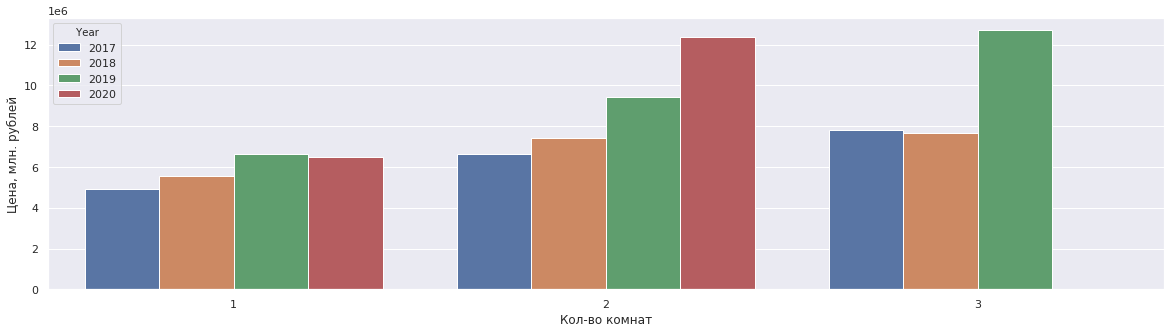

In [16]:
plt.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
ax = sns.barplot(x="Rooms", y="Price", hue="Year", data=df, estimator=np.mean, ci=None)
ax.set(xlabel='Кол-во комнат', ylabel='Цена, млн. рублей');

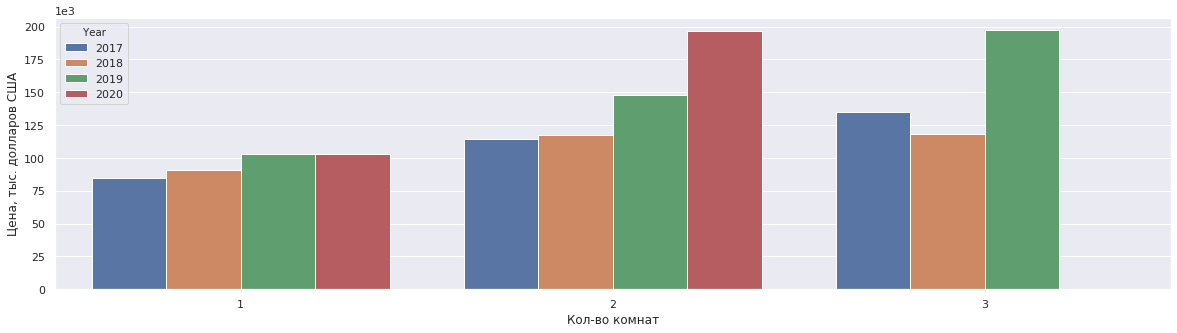

In [17]:
plt.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
ax = sns.barplot(x="Rooms", y="USD_Price", hue="Year", data=df, estimator=np.mean, ci=None)
ax.set(xlabel='Кол-во комнат', ylabel='Цена, тыс. долларов США');

In [18]:
def draw_lineplot(data):
    fig, ax = plt.subplots()
    plt.xticks(rotation=45, ha="right")
    plt.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
    sns.lineplot(x='Date', y='Price', data=data, ax=ax, color='b', label='Рубли')
    ax.set(xlabel='Дата', ylabel='Цена, млн. рублей')
    plt.legend(bbox_to_anchor=(0.01, 0.95), loc='upper left')
    ax2 = ax.twinx()
    plt.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
    sns.lineplot(x='Date', y='USD_Price', data=data, ax=ax2, color='r', label='Доллары')
    ax2.set(ylabel='Цена, тыс. долларов США');
    plt.legend(bbox_to_anchor=(0.01, 0.85), loc='upper left')
    

In [19]:
def draw_barplot_RUB(data):
    plt.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
    ax = sns.barplot(x="District", y="Price", hue="Year", data=data, estimator=np.mean, ci=None, order=np.sort(df['District'].unique()) )
    ax.set(xlabel='Округ', ylabel='Цена, млн. рублей');    

In [20]:
def draw_barplot_USD(data):
    plt.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
    ax = sns.barplot(x="District", y="USD_Price", hue="Year", data=data, estimator=np.mean, ci=None, order=np.sort(df['District'].unique()) )
    ax.set(xlabel='Округ', ylabel='Цена, тыс. долларов США');

In [21]:
len(df[df['Rooms'] == 1])

218

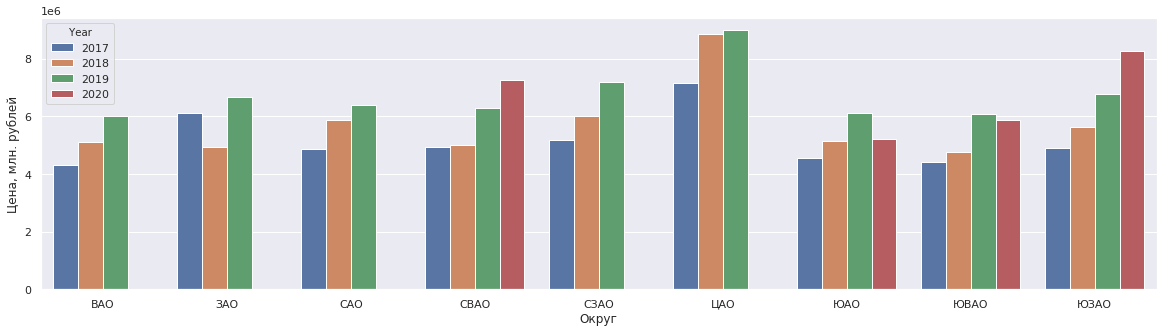

In [22]:
draw_barplot_RUB(df[df['Rooms'] == 1])

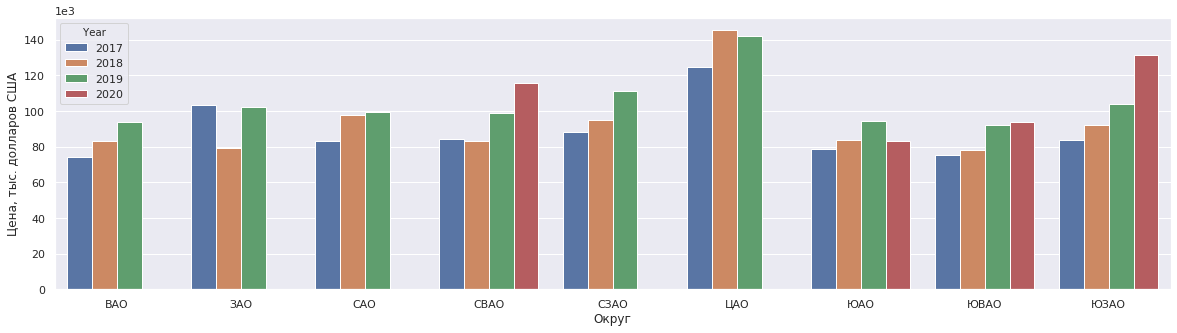

In [23]:
draw_barplot_USD(df[df['Rooms'] == 1])

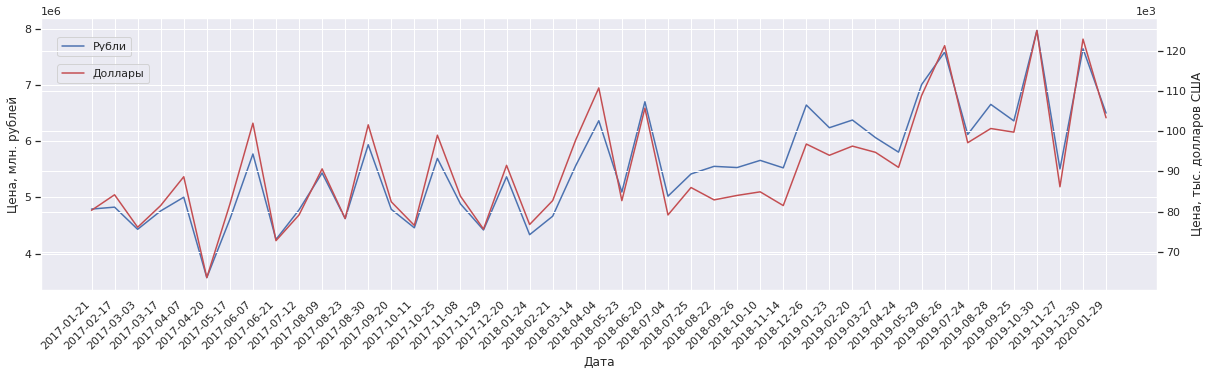

In [24]:
data = df.loc[df['Rooms'] == 1, ['Date', 'Price', 'USD_Price']].groupby('Date', as_index=False).mean()
draw_lineplot(data)

In [25]:
len(df[df['Rooms'] == 2])

154

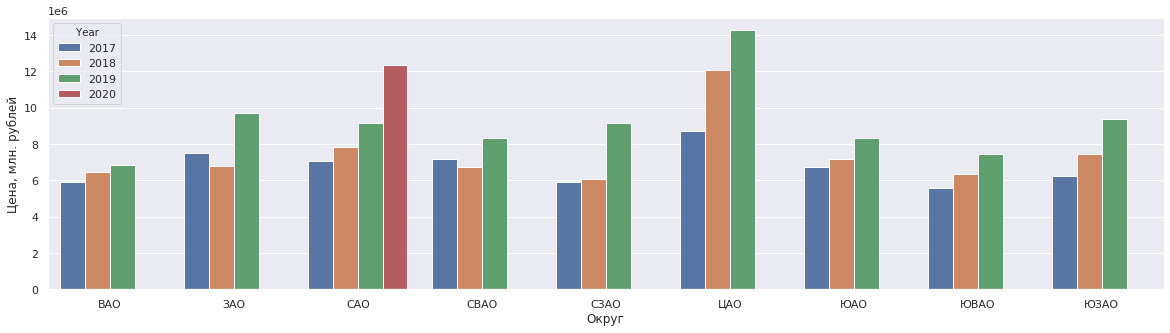

In [26]:
draw_barplot_RUB(df[df['Rooms'] == 2])

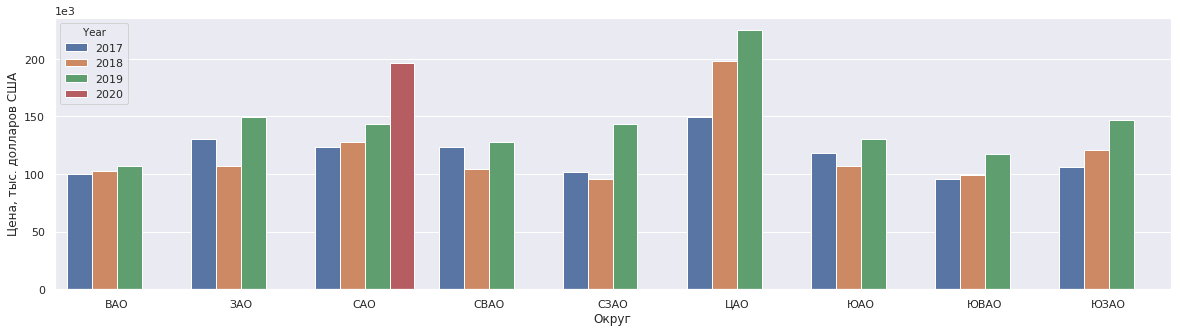

In [27]:
draw_barplot_USD(df[df['Rooms'] == 2])

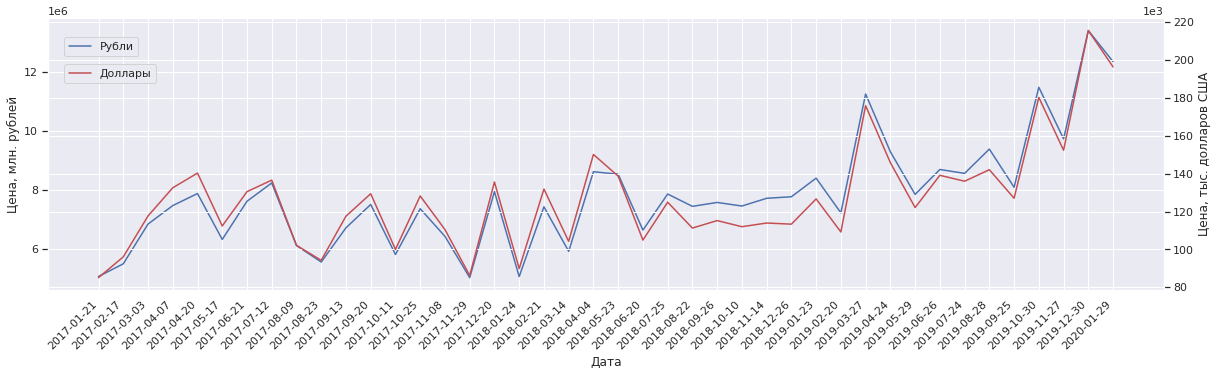

In [28]:
data = df.loc[df['Rooms'] == 2, ['Date', 'Price', 'USD_Price']].groupby('Date', as_index=False).mean()
draw_lineplot(data)

In [29]:
len(df[df['Rooms'] == 3])

18

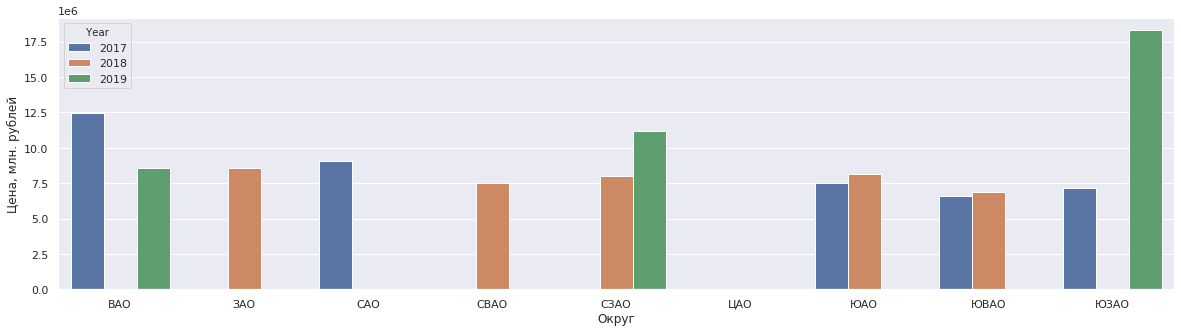

In [30]:
draw_barplot_RUB(df[df['Rooms'] == 3])

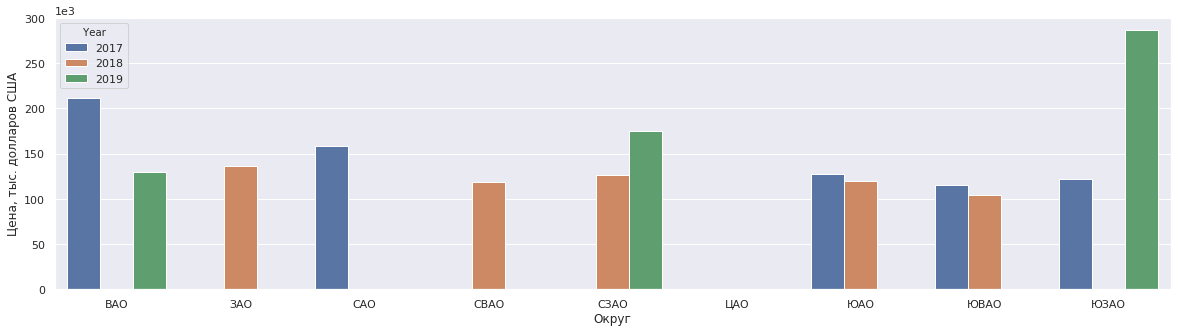

In [31]:
draw_barplot_USD(df[df['Rooms'] == 3])

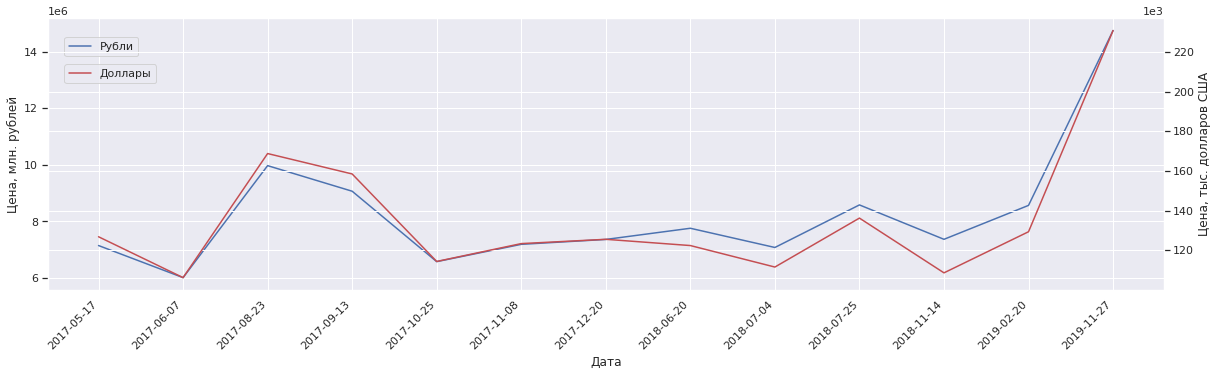

In [32]:
data = df.loc[df['Rooms'] == 3, ['Date', 'Price', 'USD_Price']].groupby('Date', as_index=False).mean()
draw_lineplot(data)